In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as pltaccuracy_score
import PyALE
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.inspection import PartialDependenceDisplay
import shap
from sklearn.inspection import plot_partial_dependence
shap.initjs()

In [121]:
train = pd.read_csv(".Data\churn_train.csv")
test = pd.read_csv(".Data\churn_test.csv")

In [122]:
train = train.drop(columns=["state"])
train = train.drop(columns=["area_code"])

In [216]:
#Insights on number of churners who has opeted for international plan
len(train[train["international_plan"] == 1]["churn"])
train[train["churn"] == 1]


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
8,65,0,0,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,1
12,161,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,1
17,77,0,0,0,62.4,89,10.61,169.9,121,14.44,209.6,64,9.43,5.7,6,1.54,5,1
26,12,0,0,0,249.6,118,42.43,252.4,119,21.45,280.2,90,12.61,11.8,3,3.19,1,1
32,135,1,1,41,173.1,85,29.43,203.9,107,17.33,122.2,78,5.50,14.6,15,3.94,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4203,114,1,1,28,136.4,93,23.19,170.0,90,14.45,191.5,73,8.62,14.6,4,3.94,2,1
4208,90,0,0,0,104.0,104,17.68,170.9,106,14.53,158.8,99,7.15,8.7,5,2.35,4,1
4213,137,1,0,0,312.4,110,53.11,231.1,73,19.64,120.1,78,5.40,10.6,2,2.86,1,1
4243,140,0,0,0,244.7,115,41.60,258.6,101,21.98,231.3,112,10.41,7.5,6,2.03,1,1


In [209]:
#Insights on number of churners who has opted for international plan(test data)
len(test[test["international_plan"] == 1]["churn"])

77

In [211]:
#
len(test[test["total_day_calls"] < test["total_day_calls"].mean()]["churn"])

367

In [123]:
test = test.drop(columns=["state","area_code"])

In [124]:
train.churn.replace(('yes', 'no'), (1, 0), inplace=True)
train.international_plan.replace(('yes', 'no'), (1, 0), inplace=True)
train.voice_mail_plan.replace(('yes', 'no'), (1, 0), inplace=True)

In [125]:
test.international_plan.replace(('yes', 'no'), (1, 0), inplace=True)
test.voice_mail_plan.replace(('yes', 'no'), (1, 0), inplace=True)

In [126]:
# features
selected_features = train.columns[0: -1]
# target variable
target = "churn"

In [127]:
# split data
X_train,X_test,y_train,y_test = train_test_split(train[selected_features],train[target], test_size=0.30, random_state = 1)

In [128]:
decision_tree = DecisionTreeClassifier()
logistic = LogisticRegression()
neural_net = MLPClassifier()
random_forest = RandomForestClassifier()

In [129]:
models = {
    "decision tree" : decision_tree, 
    "logistic" : logistic,
    "neural_net" : neural_net,
    "random_forest": random_forest
}

In [130]:
#fitting the models
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

decision tree has been trained successfully
logistic has been trained successfully


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


neural_net has been trained successfully
random_forest has been trained successfully


In [131]:
# store training performance
performances_training = {}

for model in models:
    predictions   = models[model].predict(X_train)
    probabilities = pd.DataFrame(models[model].predict_proba(X_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
#     auc           = roc_auc_score(np.array(y_train),np.array(probabilities),multi_class = 'ovr')
    
    performances_training[model] = {"Accuracy":accuracy}
pd.DataFrame(performances_training)

,decision tree,logistic,neural_net,random_forest
Accuracy,1.0,0.85916,0.882689,0.999664


In [132]:
# store testing performance
performances_test = {}

for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    
    performances_test[model] = {"Accuracy":accuracy}

In [133]:
 pd.DataFrame(performances_test)

,decision tree,logistic,neural_net,random_forest
Accuracy,0.921569,0.865098,0.880784,0.969412


In [134]:
selected_features

Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls'],
      dtype='object')

In [135]:
# Sahpely for logistic only 

# set up explainer for ".predict" method
explainer = shap.Explainer(logistic.predict, X_test)

# compute shap values
shap_values = explainer(X_test)

Permutation explainer: 1276it [00:34, 26.06it/s]                                                                       


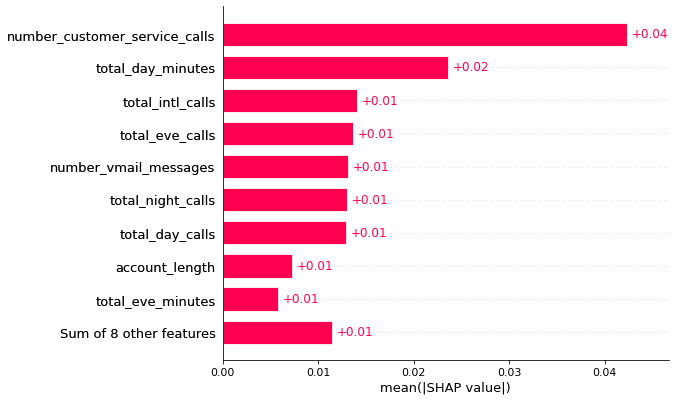

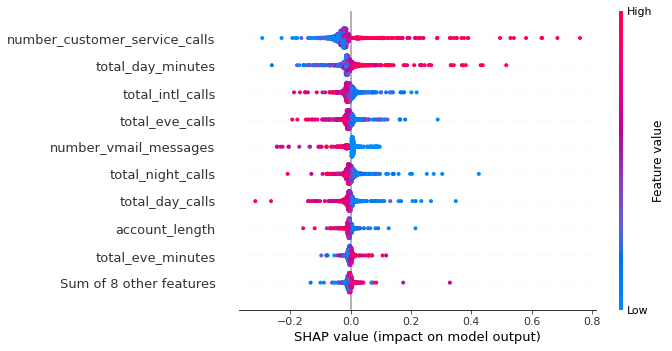

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [136]:
# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

# split population in distinct groups (uses sklearn DecisionTree)
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

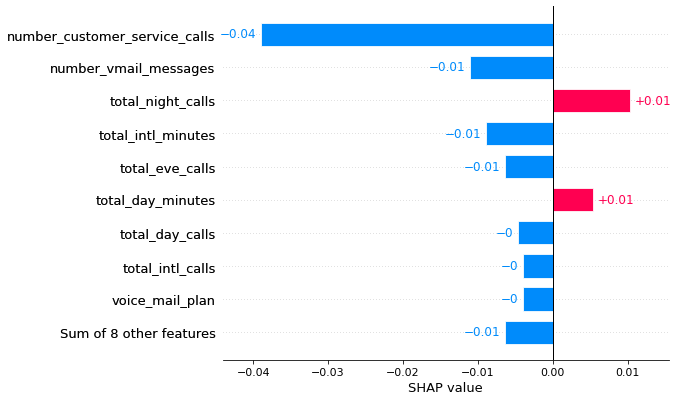

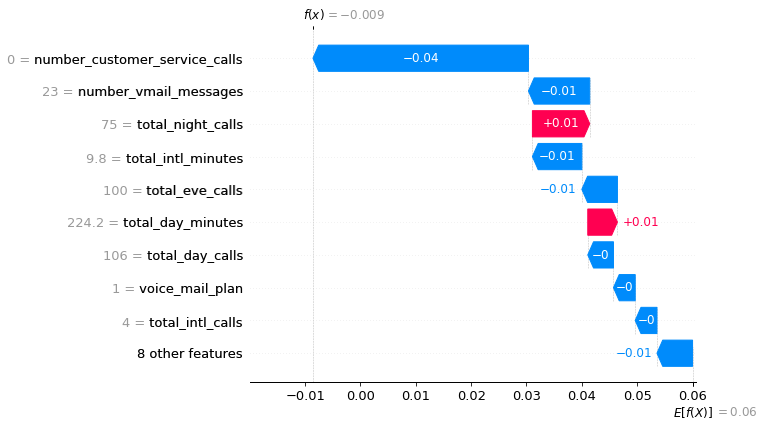

In [137]:
# explain individual instance (local)
instance = 0

# feature importance
shap.plots.bar(shap_values[instance])

# contribution to output
shap.plots.waterfall(shap_values[instance])

In [138]:
#ALE for logistic Plot

In [139]:
# adapt PyALE.ale function to incorporate classification models 
# reference: https://htmlpreview.github.io/?https://github.com/DanaJomar/PyALE/blob/master/examples/ALE%20plots%20for%20classification%20models.html
def ale(target=None, print_meanres=False, **kwargs):
    if target is not None:
        class clf():
            def __init__(self, classifier):
                self.classifier = classifier
            def predict(self, X):
                return(self.classifier.predict_proba(X)[:, target])
        clf_dummy = clf(kwargs["model"])
        kwargs["model"] = clf_dummy
    if (print_meanres & len(kwargs["feature"])==1):
        mean_response = np.mean(kwargs["model"].predict(kwargs["X"]), axis=0)
        print(f"Mean response: {mean_response:.5f}")
    return PyALE.ale(**kwargs)

PyALE._ALE_generic:INFO: Discrete feature detected.


Mean response: 0.53454


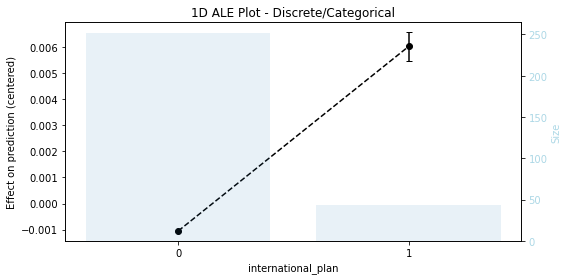

In [202]:
#ALE for Logistic

# ALE plot 1D - international_plan
ale_international_plan = ale(
    X=X_train,
    model=logistic,
    feature= ["international_plan"],
    include_CI=True,
    target=1,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.14685


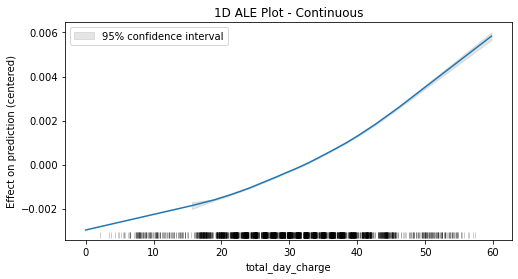

In [141]:
ale_total_day_charge = ale(
    X=X_train,
    model=logistic,
    feature= ["total_day_charge"],
    include_CI=True,
    target=1,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Discrete feature detected.


Mean response: 0.85315


PyALE._ALE_generic:INFO: Continuous feature detected.
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.14685


Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().


IndexError: index 2 is out of bounds for axis 0 with size 2

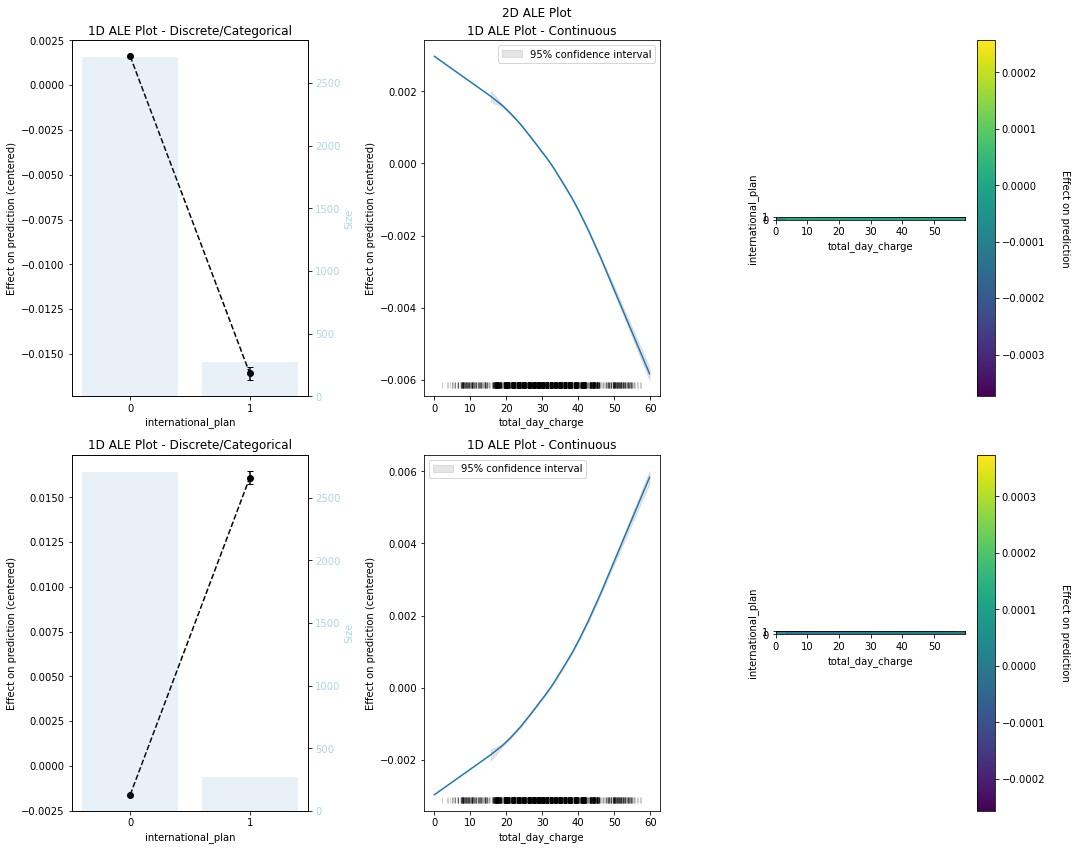

In [142]:
# ALE plots for selected features
fig, axs = plt.subplots(2, 3, figsize=(15, 12))
fig.tight_layout(pad=3)

for i in range(3):
    ale_international_plan = ale(
        X=X_train,
        model=logistic,
        feature=["international_plan"],
        include_CI=True,
        target=i,
        fig=fig,
        ax=axs[i,0], print_meanres=True)

    ale_total_day_charge = ale(
        X=X_train,
        model=logistic,
        feature=["total_day_charge"],
        include_CI=True,
        target=i,
        fig=fig,
        ax=axs[i,1])

    ale_2d = ale(
        X=X_train,
        model=logistic,
        feature=["international_plan", "total_day_charge"],
        include_CI=True,
        target=i, 
        fig=fig,
        ax=axs[i,2])
        
    ###axs[i,0].set_title(train.target_names[i])
   ## axs[i,1].set_title(train.target_names[i])
    #axs[i,2].set_title(train.target_names[i])

In [201]:
X_train.columns



Index(['account_length', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'number_customer_service_calls'],
      dtype='object')

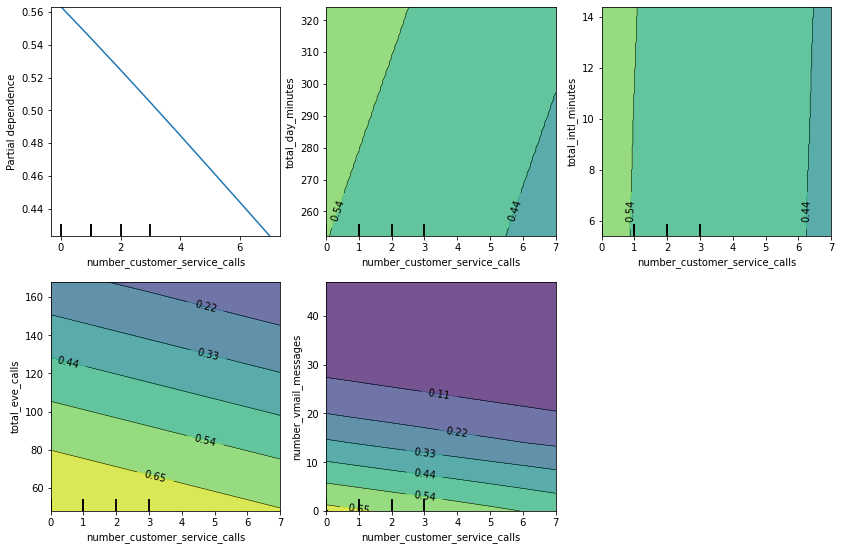

In [204]:
#pdp logistic

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(estimator=logistic, X=X_train, features = [16,(16,4),(16,13),(16,8),(16,3)], target=1,ax=ax)
fig.tight_layout(pad=2.0)







In [ ]:
#ice for logistic

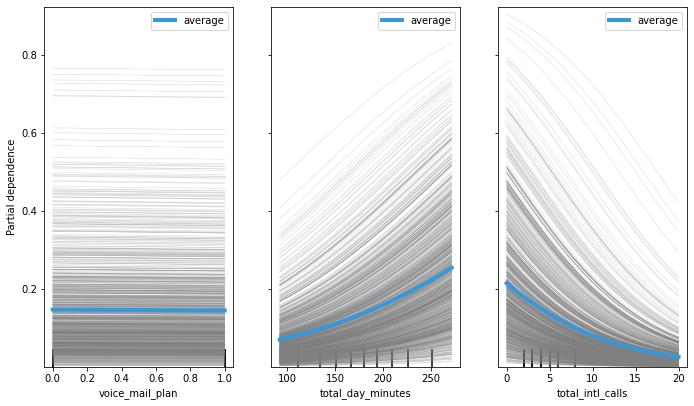

In [144]:
fig, ax = plt.subplots(figsize=(10, 6))
ice = PartialDependenceDisplay.from_estimator(estimator=logistic,
                            X=X_train,
                            features=[2,4,14],
                            kind="both",
                            ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                            pd_line_kw={"color": "#3498DB", "linewidth": 4, "alpha":1},
                            # centered=True, # will be added in the future
                            ax=ax)
fig.tight_layout(pad=2.0)

In [1]:
#Random Forest

In [17]:
# Shapely for Random Forest

# set up explainer for ".predict" method
explainer = shap.Explainer(random_forest.predict, X_test)

# compute shap values
shap_values = explainer(X_test)

Permutation explainer: 1276it [14:40,  1.43it/s]                                                                       


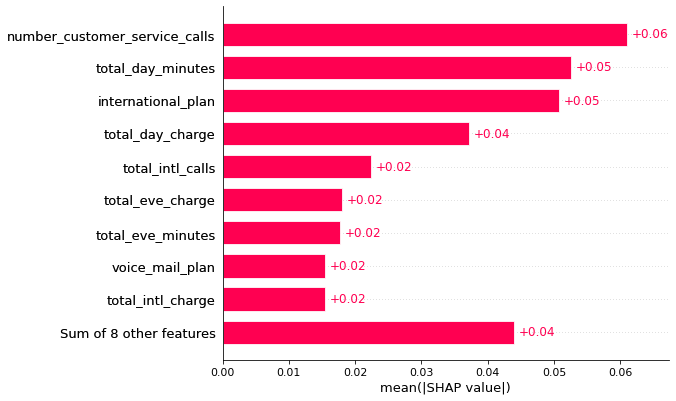

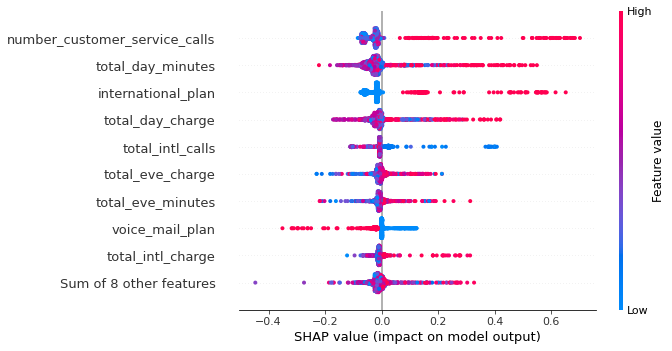

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [18]:
# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

# split population in distinct groups (uses sklearn DecisionTree)
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

In [ ]:
#number_customer_service_calls
#total_day_minutes
#total_day_charge
#total_intl_calls
#international_plan
#total_eve_charge


In [ ]:
# ALE for Random Forest

PyALE._ALE_generic:INFO: Discrete feature detected.


Mean response: 0.14198


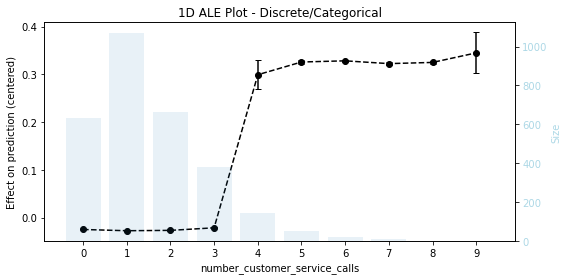

In [22]:
ale_number_customer_service_calls = ale(
    X=X_train,
    model=random_forest,
    feature= ["number_customer_service_calls"],
    include_CI=True,
    target=1,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.14198


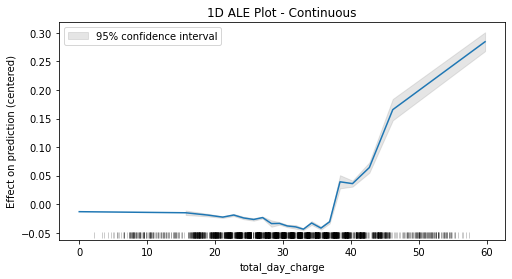

In [23]:
ale_total_day_charge = ale(
    X=X_train,
    model=random_forest,
    feature= ["total_day_charge"],
    include_CI=True,
    target=1,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.14198


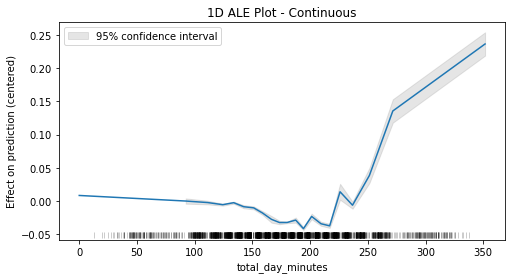

In [25]:
ale_total_day_minutes = ale(
    X=X_train,
    model=random_forest,
    feature= ["total_day_minutes"],
    include_CI=True,
    target=1,
    print_meanres=True
)

PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.14198


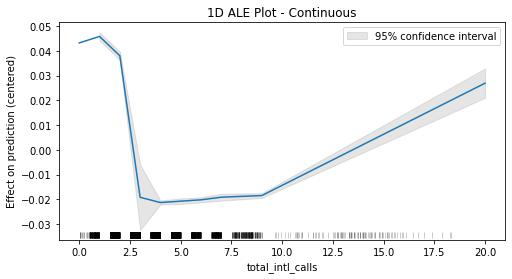

In [26]:
ale_total_intl_calls = ale(
    X=X_train,
    model=random_forest,
    feature= ["total_intl_calls"],
    include_CI=True,
    target=1,
    print_meanres=True
)



PyALE._ALE_generic:INFO: Discrete feature detected.


Mean response: 0.14198


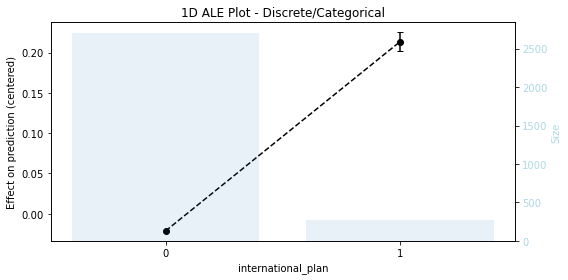

In [29]:
ale_international_plan = ale(
    X=X_train,
    model=random_forest,
    feature= ["international_plan"],
    include_CI=True,
    target=1,
    print_meanres=True
)



PyALE._ALE_generic:INFO: Continuous feature detected.


Mean response: 0.14198


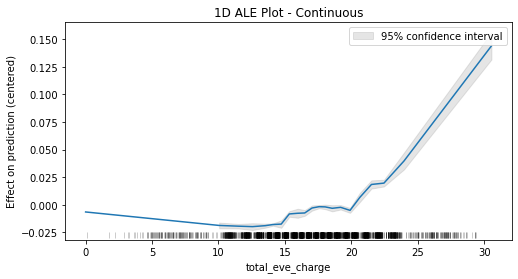

In [30]:
ale_total_eve_charge = ale(
    X=X_train,
    model=random_forest,
    feature= ["total_eve_charge"],
    include_CI=True,
    target=1,
    print_meanres=True
)

In [ ]:
#2d Ale Random Forest

In [ ]:
#ice random forest

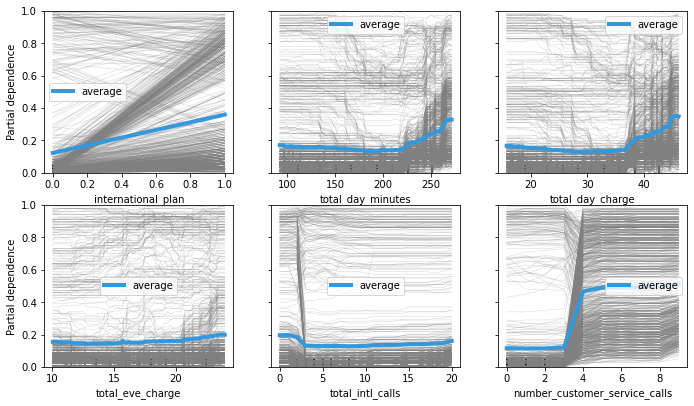

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))
ice = PartialDependenceDisplay.from_estimator(estimator=random_forest,
                            X=X_train,
                            features=[1,4,6,9,14,16],
                            kind="both",
                            ice_lines_kw={"color":"#808080","alpha": 0.3, "linewidth": 0.5},
                            pd_line_kw={"color": "#3498DB", "linewidth": 4, "alpha":1},
                            # centered=True, # will be added in the future
                            ax=ax)
fig.tight_layout(pad=2.0)

In [ ]:
#pdp for Random Forest

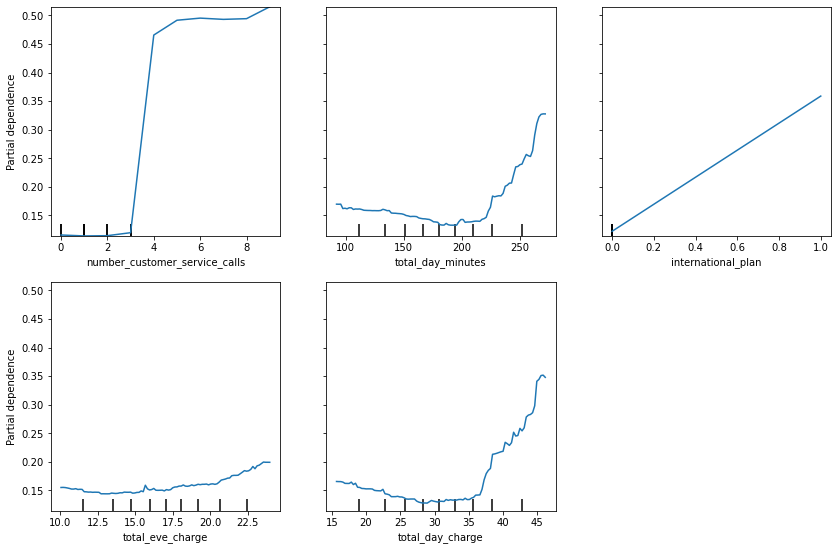

In [150]:
# pdp 1-D plot for every observation seprately
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(estimator=random_forest, X=X_train, features = [16,4,1,9,6], target=1,ax=ax)
fig.tight_layout(pad=2.0)


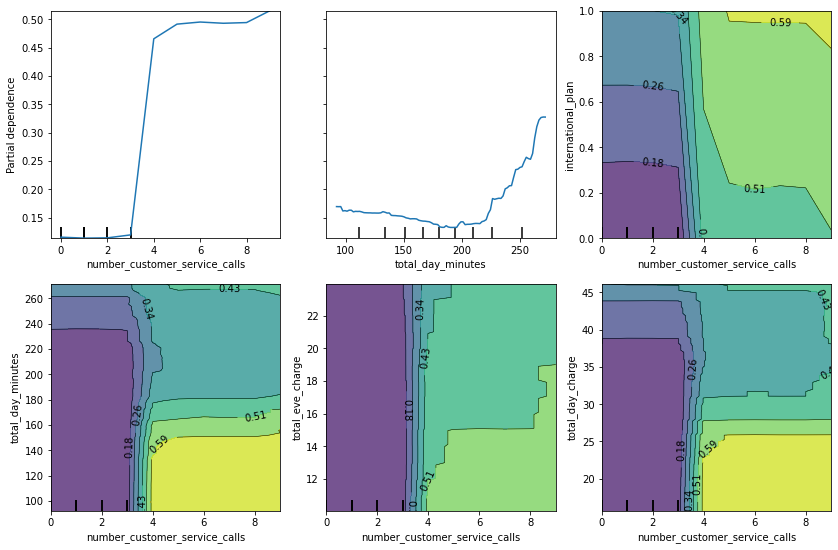

In [151]:
# pdp 2-D plot with top observation
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(estimator=random_forest, X=X_train, features = [16,4,(16,1),(16,4),(16,9),(16,6)], target=0,ax=ax)
fig.tight_layout(pad=2.0)

In [152]:
s_features = ["number_customer_service_calls","total_day_minutes","total_day_charge","total_intl_calls","international_plan","total_eve_charge"]
sel_features = train[s_features]

In [153]:
#training model with selected features 
sel_features = features[0:]
# features
sel_features

Index(['number_customer_service_calls', 'total_day_minutes',
       'total_day_charge', 'total_intl_calls', 'international_plan',
       'total_eve_charge'],
      dtype='object')

In [154]:
# features


# target variable
target = "churn"


# split data
X_train,X_test,y_train,y_test = train_test_split(train[sel_features],train[target], test_size=0.30, random_state = 1)

decision_tree = DecisionTreeClassifier()
logistic = LogisticRegression()
neural_net = MLPClassifier()
random_forest = RandomForestClassifier()

models = {   
    "logistic" : logistic,
    "random_forest": random_forest
}

#fitting the models
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")
	
# store training performance
performances_training = {}


for model in models:
    predictions   = models[model].predict(X_train)
    probabilities = pd.DataFrame(models[model].predict_proba(X_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
#     auc           = roc_auc_score(np.array(y_train),np.array(probabilities),multi_class = 'ovr')
    
    performances_training[model] = {"Accuracy":accuracy}
pd.DataFrame(performances_training)




 

decision tree has been trained successfully
logistic has been trained successfully
neural_net has been trained successfully
random_forest has been trained successfully


,decision tree,logistic,neural_net,random_forest
Accuracy,1.0,0.863866,0.876975,1.0


In [155]:
# store testing performance
performances_test = {}

for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    
    performances_test[model] = {"Accuracy":accuracy}

pd.DataFrame(performances_test)

,decision tree,logistic,neural_net,random_forest
Accuracy,0.89098,0.866667,0.876863,0.932549


In [160]:
test_features = ["number_customer_service_calls","total_day_minutes","total_day_charge","total_intl_calls","international_plan","total_eve_charge"]
tes_features = test[test_features]

In [161]:
model = "random_forest"
predictions   = models[model].predict(tes_features)
probabilities = pd.DataFrame(models[model].predict_proba(tes_features))[1]

In [162]:
predictions

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [163]:
test["churn"] = predictions

In [167]:
final_features = ["number_customer_service_calls","total_day_minutes","total_day_charge","total_intl_calls","international_plan","total_eve_charge","churn"]
test[final_features]

,number_customer_service_calls,total_day_minutes,total_day_charge,total_intl_calls,international_plan,total_eve_charge,churn
0,1,265.1,45.07,3,0,16.78,1
1,0,223.4,37.98,6,1,18.75,0
2,4,120.7,20.52,6,0,26.11,1
3,3,190.7,32.42,3,0,18.55,0
4,3,124.3,21.13,5,0,23.55,0
...,...,...,...,...,...,...,...
745,0,119.4,20.30,7,0,19.24,0
746,3,177.2,30.12,2,0,22.99,0
747,3,184.2,31.31,2,0,21.83,0
748,1,140.6,23.90,4,0,14.69,0


In [ ]:
#running the model on subset data : considered data where total day minutes is greater than 250 

In [176]:
subset_data = train[train["total_day_minutes"] > 250]
subset_data


,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
2,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
7,141,1,1,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0
12,161,0,0,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,1
49,116,0,1,34,268.6,83,45.66,178.2,142,15.15,166.3,106,7.48,11.6,3,3.13,2,0
53,43,1,0,0,251.5,105,42.76,212.8,104,18.09,157.8,67,7.10,9.3,4,2.51,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180,77,1,0,0,323.7,106,55.03,139.2,99,11.83,204.4,89,9.20,8.5,3,2.30,6,1
4185,110,0,0,0,281.2,78,47.80,302.3,89,25.70,188.4,92,8.48,8.5,4,2.30,0,1
4199,132,0,0,0,265.8,122,45.19,285.1,90,24.23,183.6,124,8.26,13.6,9,3.67,2,1
4213,137,1,0,0,312.4,110,53.11,231.1,73,19.64,120.1,78,5.40,10.6,2,2.86,1,1


In [177]:
# split data
X_train,X_test,y_train,y_test = train_test_split(subset_data[selected_features],subset_data[target], test_size=0.30, random_state = 1)

In [178]:
models = {     
    "logistic" : logistic,
    "random_forest": random_forest}

#fitting the models
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")
	
# store training performance
performances_training = {}


for model in models:
    predictions   = models[model].predict(X_train)
    probabilities = pd.DataFrame(models[model].predict_proba(X_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
#     auc           = roc_auc_score(np.array(y_train),np.array(probabilities),multi_class = 'ovr')
    
    performances_training[model] = {"Accuracy":accuracy}
pd.DataFrame(performances_training)



# store testing performance
performances_test = {}

for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    
    performances_test[model] = {"Accuracy":accuracy}

pd.DataFrame(performances_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


logistic has been trained successfully
random_forest has been trained successfully


,logistic,random_forest
Accuracy,0.795276,0.92126


In [179]:
# Sahpely for subset data 

# set up explainer for ".predict" method
explainer = shap.Explainer(random_forest.predict, X_test)

# compute shap values
shap_values = explainer(X_test)


Permutation explainer: 128it [00:51,  1.96it/s]                                                                                                                                                                   


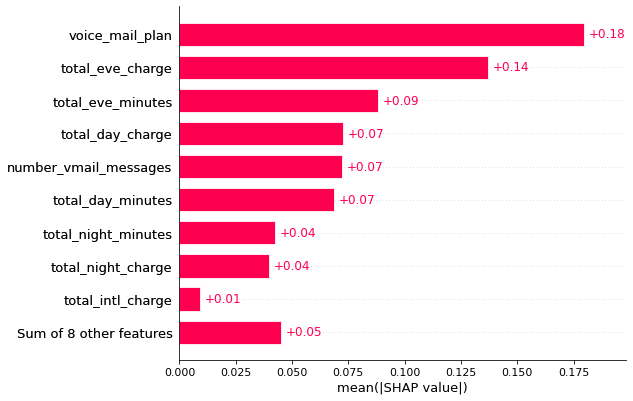

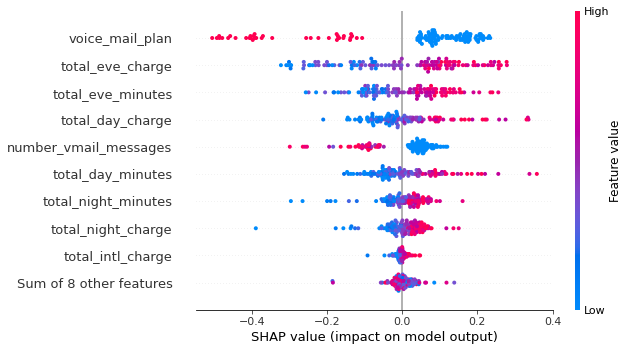

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [180]:
# feature importance (global)

# bar chart
shap.plots.bar(shap_values)

# individual dots for each instance
shap.plots.beeswarm(shap_values)

# split population in distinct groups (uses sklearn DecisionTree)
shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

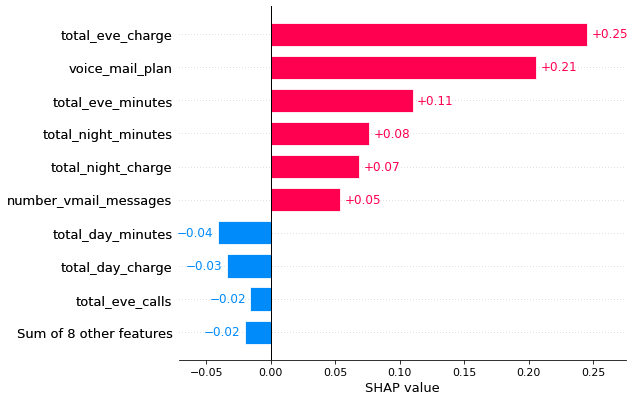

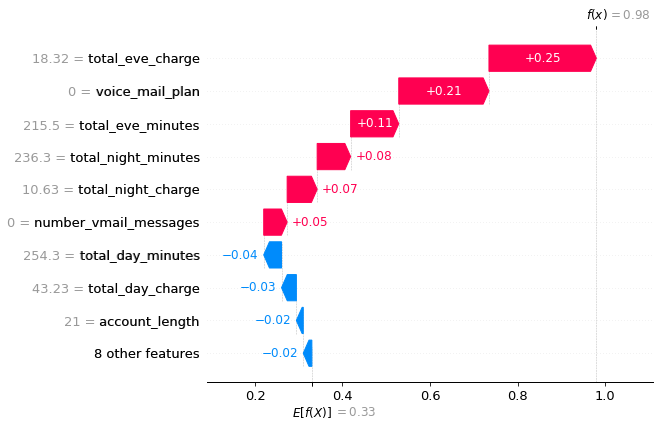

In [181]:
# explain individual instance (local)
instance = 0

# feature importance
shap.plots.bar(shap_values[instance])

# contribution to output
shap.plots.waterfall(shap_values[instance])